In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
import cv2
import sys
import numpy as np
import os
from tqdm import tqdm 

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [11]:
import time

In [2]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [3]:
def tv_norm(input, tv_beta):
    # regularize m in tota-variation norm 
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)

def save(mask, img, blurred, name=''):
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0))

    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)

    heatmap = np.float32(heatmap) / 255
    cam = 1.0*heatmap + np.float32(img)/255
    cam = cam / np.max(cam)

    img = np.float32(img) / 255
    perturbated = np.multiply(1 - mask, img) + np.multiply(mask, blurred)	
    
    pdf = PdfPages('perturb/{}.pdf'.format(name))
    plt.figure(figsize=(9.6, 2.4))
    legs = ['perturbated', 'heatmap', 'mask', 'cam']
    for i,x in enumerate([perturbated, heatmap, mask, cam]):
        x = (x - x.min()) / (x.max() - x.min() + 1e-6)
        x = np.uint8(255*x)
                 
        plt.subplot(1, 4, i+1)
        plt.imshow(x)
        plt.title(legs[i])
        plt.axis('off')
        plt.colorbar()
    
    plt.tight_layout()
    pdf.savefig()
    pdf.close()
    # cv2.imwrite("perturbated.png", np.uint8(255*perturbated))
    # cv2.imwrite("heatmap.png", np.uint8(255*heatmap))
    # cv2.imwrite("mask.png", np.uint8(255*mask))
    # cv2.imwrite("cam.png", np.uint8(255*cam))


def numpy_to_torch(img, requires_grad=True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v

def load_model():
    model = models.vgg19(pretrained=True)
    model.eval()
    if use_cuda:
        model.cuda()

    for p in model.features.parameters():
        p.requires_grad = False
    for p in model.classifier.parameters():
        p.requires_grad = False

    return model

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
root_path='/home/yangwenhao/project/SpeakerVerification-pytorch/'

In [5]:
tv_beta = 3
learning_rate = 0.1
max_iterations = 500
l1_coeff = 0.01
tv_coeff = 0.2

model = load_model()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/yangwenhao/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

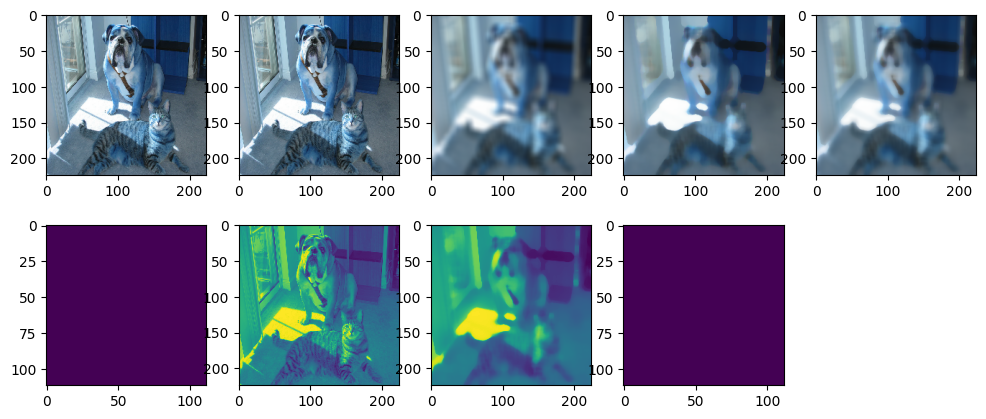

In [26]:
original_img = cv2.imread(root_path + '/Misc/data/cat_dog.jpg', 1)
original_img = cv2.resize(original_img, (224, 224))
mask_len = 112
max_iterations = 500

tv_beta = 3
learning_rate = 0.1

l1_coeff = 0.01
tv_coeff = 0.2

plt.figure(figsize=(12, 5))
plt.subplot(2, 5, 1)
plt.imshow(original_img)

img = np.float32(original_img) / 255

plt.subplot(2, 5, 2)
plt.imshow(img)

blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5) # 高斯模糊 核11x11 标准差5

plt.subplot(2, 5, 3)
plt.imshow(blurred_img1)

blurred_img2 = np.float32(cv2.medianBlur(original_img, 11))/255 # 中值滤波模糊 核11
plt.subplot(2, 5, 4)
plt.imshow(blurred_img2)

blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
plt.subplot(2, 5, 5)
plt.imshow(blurred_img_numpy)

mask_init = np.ones((mask_len, mask_len), dtype = np.float32)                  # 28x28 的初始化mask
plt.subplot(2, 5, 6)
plt.imshow(mask_init)             

# Convert to torch variables
img = preprocess_image(img)                                  # mean and std norm
plt.subplot(2, 5, 7)
plt.imshow(img.detach().cpu().squeeze().mean(dim=0))

blurred_img = preprocess_image(blurred_img2)                  # 中值滤波的图像 mean and std norm

plt.subplot(2, 5, 8)
plt.imshow(blurred_img.detach().cpu().squeeze().mean(dim=0))

plt.subplot(2, 5, 9)
plt.imshow(mask_init)

# upsampling from a low mask
if use_cuda:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()
    soft_max = torch.nn.Softmax(dim=-1).cuda()
else:
    soft_max = torch.nn.Softmax(dim=-1)
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))

In [29]:
mask = numpy_to_torch(mask_init) # 28x28  torch mask
optimizer = torch.optim.Adam([mask], lr=learning_rate)  # 优化的 28*28 mask

target = soft_max(model(img))                           # 取概率最大的类
category = np.argmax(target.cpu().data.numpy())
print("Category with highest probability: ", category)
print("Optimizing.. ")
max_iterations = 500

start = time.time()
for i in tqdm(range(max_iterations), ncols=50, total=max_iterations):
    upsampled_mask = upsample(mask)                     # upsample mask to imgs ?
    # The single channel mask is used with an RGB image, 
    # so the mask is duplicated to have 3 channel,
    upsampled_mask = \
        upsampled_mask.expand(1, 3, upsampled_mask.size(2), \
                                    upsampled_mask.size(3))

    # Use the mask to perturbated the input image.
    # linear combine blurred image with original image
    perturbated_input = img.mul(upsampled_mask) + \
                        blurred_img.mul(1-upsampled_mask)

    noise = np.zeros((224, 224, 3), dtype=np.float32)
    cv2.randn(noise, 0, 0.2)
    noise = numpy_to_torch(noise)
    perturbated_input = perturbated_input + noise # additive noise

    outputs = soft_max(model(perturbated_input))
    # lamda_1 * |1-M|_1 + lamda_2 \sum |M_{total-variation}|_3 + P_x
    loss = l1_coeff * torch.mean(torch.abs(1 - mask)) + \
            tv_coeff * tv_norm(mask, tv_beta) + outputs[0, category]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Optional: clamping seems to give better results
    mask.data.clamp_(0, 1)
    
stop = time.time()
print('Duration: ', stop-start)

Category with highest probability:  243
Optimizing.. 


100%|███████████| 500/500 [00:08<00:00, 57.36it/s]

Duration:  8.724479913711548


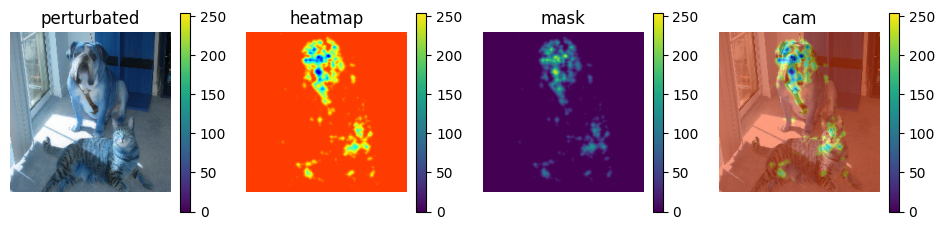

In [30]:
name = '{}.{}'.format(mask_len, max_iterations)
upsampled_mask = upsample(mask)
save(upsampled_mask, original_img, blurred_img_numpy,
     name=name)

In [61]:
mask = numpy_to_torch(mask_init) # 28x28  torch mask
optimizer = torch.optim.Adam([mask], lr=learning_rate*2)  # 优化的 28*28 mask

target = soft_max(model(img))                           # 取概率最大的类
category = np.argmax(target.cpu().data.numpy())
print("Category with highest probability: ", category)
print("Optimizing.. ")

repeat = 2
if img.shape[0] == 1:
    the_img = img.repeat(repeat,1,1,1)
else:
    the_img = img.clone()
max_iterations = int(500 / repeat * 1.25)

start = time.time()
for i in tqdm(range(max_iterations), ncols=50, total=max_iterations):
    upsampled_mask = upsample(mask)                     # upsample mask to imgs ?
    # The single channel mask is used with an RGB image, 
    # so the mask is duplicated to have 3 channel,
    upsampled_mask = \
        upsampled_mask.expand(1, 3, upsampled_mask.size(2), \
                                    upsampled_mask.size(3))
    # upsampled_mask = upsampled_mask.repeat(repeat,1,1,1)
    
    # print(upsampled_mask.shape, img.shape)
    # Use the mask to perturbated the input image.
    # linear combine blurred image with original image
    perturbated_input = the_img.mul(upsampled_mask) + \
                        blurred_img.mul(1-upsampled_mask)

    noises = []
    for i in range(repeat):
        noise = np.zeros((224, 224, 3), dtype=np.float32)
        cv2.randn(noise, 0, 0.2)
        noises.append(numpy_to_torch(noise))
    
    noise = torch.cat(noises, dim=0)
    # print(noise.shape)
    perturbated_input = perturbated_input + noise # additive noise

    outputs = soft_max(model(perturbated_input))
    # lamda_1 * |1-M|_1 + lamda_2 \sum |M_{total-variation}|_3 + P_x
    loss = l1_coeff * torch.mean(torch.abs(1 - mask)) + \
            tv_coeff * tv_norm(mask, tv_beta) + outputs[:, category].mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Optional: clamping seems to give better results
    mask.data.clamp_(0, 1)
    
stop = time.time()
print('Duration: ', stop-start)

Category with highest probability:  243
Optimizing.. 


100%|███████████| 312/312 [00:07<00:00, 43.54it/s]

Duration:  7.173222064971924


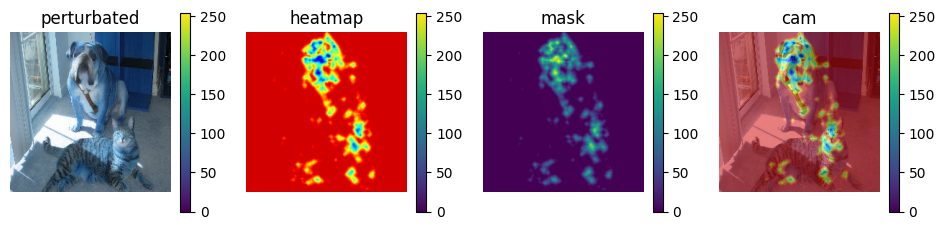

In [62]:
name = '{}.{}.{}'.format(mask_len, max_iterations, repeat)
upsampled_mask = upsample(mask)
save(upsampled_mask, original_img, blurred_img_numpy,
     name=name)

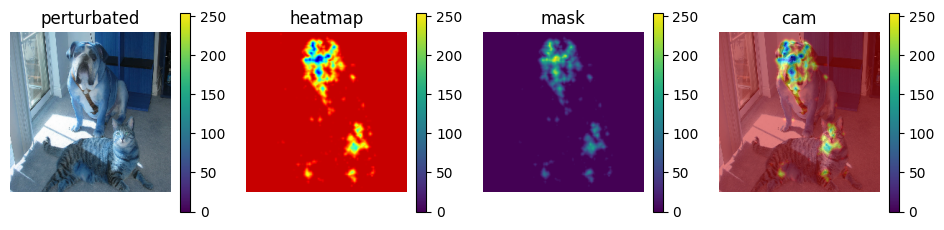

In [56]:
name = '{}.{}.{}'.format(mask_len, max_iterations, repeat)
upsampled_mask = upsample(mask)
save(upsampled_mask, original_img, blurred_img_numpy,
     name=name)